# Data Mining the Water Table

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import seaborn as sns


In [3]:
x_train = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/x_train.csv', parse_dates = ['date_recorded'])
y_train = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/y_train.csv')
x_test = pd.read_csv('https://raw.githubusercontent.com/kayoyin/datasets/master/x_test.csv', parse_dates = ['date_recorded'])

In [4]:
print(x_train.shape, y_train.shape, x_test.shape)

(59400, 40) (59400, 2) (14850, 40)


In [5]:
y_num = y_train.replace(['functional','non functional', 'functional needs repair'], [0,1,2]) # replace labels by numerical values
data_viz = pd.concat([x_train,y_train['status_group']],axis=1) # data and target in one DF
labels = pd.get_dummies(y_train) #one-hot encoding of target
data = x_train.append(x_test) # merge train and test data for processing together
data.shape

(74250, 40)

In [6]:
data.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

# Data Cleaning

We inspect each feature one by one

TODO: Improve cleaning of features funder, installer

In [7]:
# feature with null values: funder, installer, subvillage, public_meeting, scheme_management, scheme_name, permit
data.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    4504
gps_height                   0
installer                 4532
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 470
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            4155
recorded_by                  0
scheme_management         4846
scheme_name              35258
permit                    3793
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


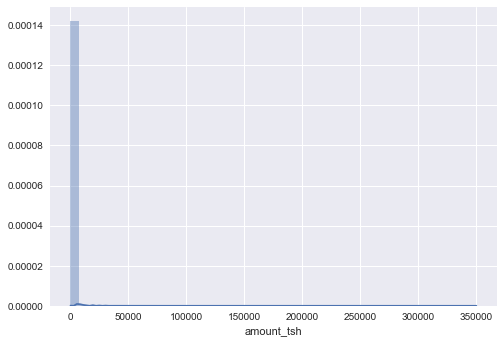

In [8]:
#1) amount_tsh

sns.distplot(data.amount_tsh)

plt.show()

#too many 0 values useless
data.drop('amount_tsh', axis = 1, inplace = True)

In [9]:
#2) make date_recorded useful

# Function retrieved and adapted from fastai library
def add_datepart(df, fldname):
    fld = df[fldname]
    targ_pre = re.sub('[Dd]ate$','', fldname)
    df[targ_pre+'Month'] = getattr(fld.dt,'Month'.lower())
    df[targ_pre+'Elapsed'] = (fld - fld.min()).dt.days
    df.drop(fldname, axis=1, inplace = True)
#add_datepart(x_test, 'date_recorded',x_test['date_recorded'].min())

In [10]:
#Misstype for years 2001, 2002, 2004?
copy = data
data.loc[data['date_recorded'].dt.year < 2010, 'date_recorded'] = data.loc[data['date_recorded'].dt.year < 2010, 'date_recorded'].apply(lambda x: x + np.timedelta64(10, 'Y'))
data['year_recorded'] = data.date_recorded.apply(lambda x : int(str(x)[0:4]))

In [11]:
add_datepart(data, 'date_recorded')

In [12]:
#3) funder: too many unique and null values,drop
len(data.funder.unique())
data.drop('funder',axis = 1, inplace = True)

In [13]:
#4) gps height
data.loc[data.gps_height == 0, 'gps_height'] = np.nan
data.gps_height.fillna(data.groupby(['subvillage'])['gps_height'].transform('mean'), inplace=True)
data.gps_height.fillna(data.groupby(['ward'])['gps_height'].transform('mean'), inplace=True)
data.gps_height.fillna(data.groupby(['lga'])['gps_height'].transform('mean'), inplace=True)
data.gps_height.fillna(data.groupby(['region_code'])['gps_height'].transform('mean'), inplace=True)
data.gps_height.isnull().sum()

0

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


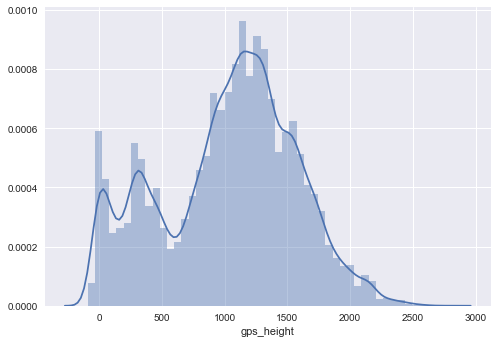

In [14]:
sns.distplot(data.gps_height)
plt.show()

In [15]:
#5) installer
len(data.installer.unique())
data.drop('installer',axis = 1,inplace=True)


In [16]:
#6) longitude 
data.loc[data.longitude == 0, 'longitude'] = np.nan
data.longitude.fillna(data.groupby(['subvillage'])['longitude'].transform('mean'), inplace=True)
data.longitude.fillna(data.groupby(['ward'])['longitude'].transform('mean'), inplace=True)
data.longitude.fillna(data.groupby(['lga'])['longitude'].transform('mean'), inplace=True)
data.longitude.isnull().sum()

0

In [17]:
data.longitude = data.longitude.round(2)

In [18]:
#7) latitude
data.loc[data.latitude > -1e-2, 'latitude'] = np.nan
data.latitude.fillna(data.groupby(['subvillage'])['latitude'].transform('mean'), inplace=True)
data.latitude.fillna(data.groupby(['ward'])['latitude'].transform('mean'), inplace=True)
data.latitude.fillna(data.groupby(['lga'])['latitude'].transform('mean'), inplace=True)

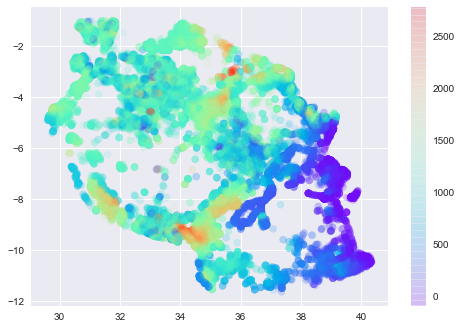

In [19]:
# idk why there's a line of 0 latitude??? update fixed it kind of brutely but it works
# plot data points with gps height as colors seems fair
plt.scatter(data.longitude, data.latitude, alpha = .1, c = data.gps_height, cmap = 'rainbow')
plt.colorbar()
plt.show()

In [20]:
#8) wpt_name
print(len(data.wpt_name.unique()))
data.drop('wpt_name', axis=1, inplace = True)

45684


In [21]:
#9) num_private
data.drop('num_private', axis=1, inplace = True)

In [22]:
#10) basin
data.groupby(['basin'])['id'].count().sort_values()

basin
Lake Rukwa                  3059
Ruvuma / Southern Coast     5587
Lake Nyasa                  6332
Wami / Ruvu                 7577
Lake Tanganyika             8052
Internal                    9642
Rufiji                      9987
Pangani                    11143
Lake Victoria              12871
Name: id, dtype: int64

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


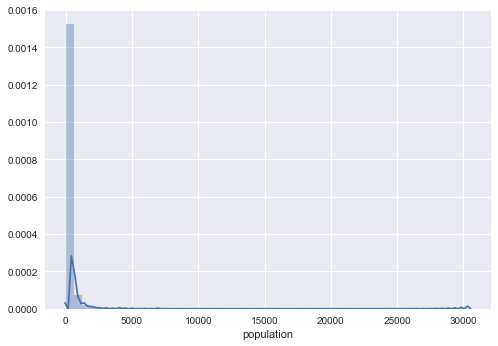

In [23]:
#11) geographic locations redundant with gps coordinates,drop at end
#12)population
data.loc[data.population == 0, 'population'] = np.nan
data.population.fillna(data.groupby(['subvillage'])['population'].transform('median'), inplace=True)
data.population.fillna(data.groupby(['ward'])['population'].transform('median'), inplace=True)
data.population.fillna(data.groupby(['lga'])['population'].transform('median'), inplace=True)
data.population.fillna(data.groupby(['region_code'])['population'].transform('median'), inplace=True)
sns.distplot(data.population)
plt.show()


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


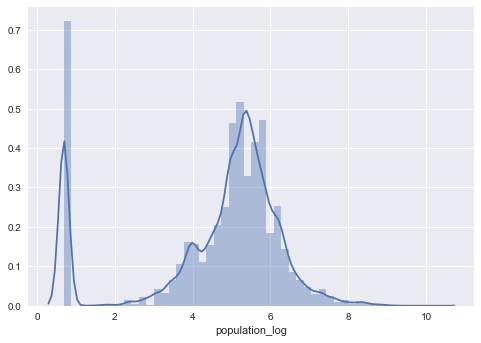

In [24]:
data['population_log'] = np.log1p(data.population)
data.drop('population', axis=1, inplace = True)
sns.distplot(data.population_log);
plt.show()

In [25]:
#13) public_meeting
data.groupby(['public_meeting']).size()
data.public_meeting.fillna(value= 1, inplace = True) 
data.public_meeting = data.public_meeting.replace([True, False], [1,0])

In [26]:
#14) recorded_by
data.groupby(['recorded_by']).size().sort_values(ascending=False)
data.drop('recorded_by', axis=1, inplace = True)

In [27]:
#15) scheme management
data.scheme_management.fillna('other', inplace=True)
data.scheme_management.replace('None', 'other', inplace = True)
data.groupby(['scheme_management']).size().sort_values(ascending=False)

scheme_management
VWC                 45917
WUG                  6496
other                4847
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
dtype: int64

In [28]:
# 16) scheme_name
data.groupby(['scheme_name']).size()
data.drop('scheme_name',axis = 1, inplace = True)

In [29]:
# 17) permit (doesn't sort well: 1:3, 2:3)
data.groupby(['permit']).size()
data.drop('permit',axis = 1, inplace = True)

In [30]:
#18) construction year
data.loc[data.construction_year == 0, 'construction_year'] = np.nan
data.construction_year.isnull().sum()

25969

In [31]:
data.construction_year.fillna(data.groupby(['subvillage'])['construction_year'].transform('median'), inplace=True)
data.construction_year.fillna(data.groupby(['ward'])['construction_year'].transform('median'), inplace=True)
data.construction_year.fillna(data.groupby(['lga'])['construction_year'].transform('median'), inplace=True)
data.construction_year.fillna(data.groupby(['region_code'])['construction_year'].transform('median'), inplace=True)
data.construction_year = data.construction_year.round(0)


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


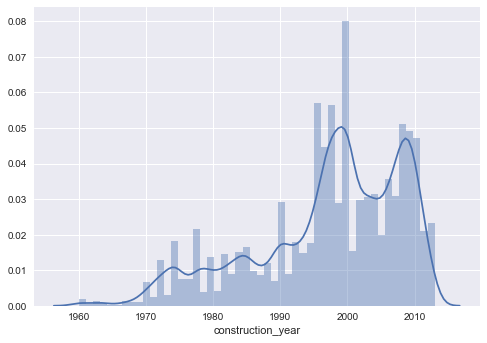

In [32]:
sns.distplot(data.construction_year)
plt.show()

In [33]:
#19) extraction type
data.groupby(['extraction_type','extraction_type_group','extraction_type_class']).size()
data.drop(['extraction_type','extraction_type_group'], axis = 1, inplace = True)

In [34]:
#20) management
data.groupby(['management','management_group']).size() 
data.drop('management_group', inplace = True, axis = 1)

In [35]:
# 21) payment
data.groupby(['payment','payment_type']).size() 
data.drop('payment', inplace = True, axis = 1)

In [36]:
#22) water quality
data.groupby(['water_quality','quality_group']).size() 
data.drop('quality_group', inplace = True, axis = 1) #same with more info

In [37]:
data.groupby(['quantity','quantity_group']).size() 
data.drop('quantity_group', inplace = True, axis = 1) #identical

In [38]:
data.groupby(['source','source_class', 'source_type']).size() 
data.drop('source_type', inplace = True, axis = 1)

In [39]:
data.groupby(['waterpoint_type','waterpoint_type_group']).size() 
data.drop('waterpoint_type_group', inplace = True, axis = 1)

In [40]:
data.columns

Index(['id', 'gps_height', 'longitude', 'latitude', 'basin', 'subvillage',
       'region', 'region_code', 'district_code', 'lga', 'ward',
       'public_meeting', 'scheme_management', 'construction_year',
       'extraction_type_class', 'management', 'payment_type', 'water_quality',
       'quantity', 'source', 'source_class', 'waterpoint_type',
       'year_recorded', 'date_recordedMonth', 'date_recordedElapsed',
       'population_log'],
      dtype='object')

In [41]:
data.drop(['subvillage','region','region_code','district_code','lga','ward'],axis = 1, inplace = True)

In [42]:
data['age'] = data.year_recorded - data.construction_year
data.groupby(['age']).size().sort_values()
data.loc[data.age < 0, 'age'] = 0

In [43]:
x_train_clean = data[:len(x_train)]
x_test_clean = data[len(x_train):]
x_test.id == x_test_clean.id

0        True
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28       True
29       True
         ... 
14820    True
14821    True
14822    True
14823    True
14824    True
14825    True
14826    True
14827    True
14828    True
14829    True
14830    True
14831    True
14832    True
14833    True
14834    True
14835    True
14836    True
14837    True
14838    True
14839    True
14840    True
14841    True
14842    True
14843    True
14844    True
14845    True
14846    True
14847    True
14848    True
14849    True
Name: id, Length: 14850, dtype: bool

In [44]:
x_train_clean.to_csv('xtrain_clean.csv')
x_test_clean.to_csv('xtest_clean.csv')